In [1]:
import os
print(os.environ['LD_LIBRARY_PATH'])
!echo $LD_LIBRARY_PATH

/usr/lib/R/lib:/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server
/usr/lib/R/lib:/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server


In [2]:
# Import modules
import tensorflow as tf
from tensorflow import keras as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_hub as hub
from keras.models import load_model

import pandas as pd
import numpy as np
import PIL
import logging
import os

import zipfile
import shutil

from datetime import datetime

# for figures
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import seaborn as sns

# for the Grad-CAMs
from IPython.display import Image, display
import matplotlib.cm as cm

#Working Directory on A4 Computer (GoPro and V2 data are on the A4 Computer)

files = os.listdir()
    
os.chdir("/home/scottweichenthal/Dropbox/IMAGINE Project/MSSI_Project/")
cwd = os.getcwd()
print("Current working directory:", cwd)


#This code allows GPU memory allocation to grow as needed
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    

Current working directory: /home/scottweichenthal/Dropbox/IMAGINE Project/MSSI_Project


2024-06-05 14:56:24.277181: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-05 14:56:24.277475: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-05 14:56:24.277716: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-05 14:56:24.277953: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-05 14:56:24.304086: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [3]:
# Check GPU memory
!nvidia-smi

Wed Jun  5 14:56:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A4000               On  | 00000000:01:00.0  On |                  Off |
| 41%   39C    P8              16W / 140W |    141MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
#  Prints the Tensorflow, Keras versions, and number of GPUs
print(tf.__version__)
print(K.__version__)
print("TensorFlow Hub version:", hub.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.7.0
2.7.0
TensorFlow Hub version: 0.16.1
Num GPUs Available:  4


In [5]:
#Which Python Version
from platform import python_version

print(python_version())

3.9.7


In [6]:
# Read metadata for compiled data you want to use for CNN model development
#This version has GoPro in trn and val sets
#metadata = pd.read_csv("compiled data/metadata_goproUFP_V2_V3_15012024.csv", low_memory=False)

#This version has GoPro data only in trn set (as opposed to random split between trn,val,tst)
# metadata = pd.read_csv("compiled data/metadata_goproUFP_V2_V3_04042024.csv", low_memory=False)
# Train: 100% GoPro + 80% Imagine V2
# Val: 10% Imagine V2
# Tst: 10% Imagine V2
# External Test: 100% Imagine V3


#This compiled file incorporate all existing data with GoPro in training set only. Rishabh Please use this file!

metadata = pd.read_csv("compiled data/metadata_goproUFP_V2_V3_04252024.csv", low_memory=False)
# Train: 100% GoPro + 80% Imagine V2 and V3
# Val: 10% Imagine V2 and V3
# Tst: 10% Imagine V2 and V3

In [7]:
# Look at data
metadata.head(10)

,datetime,image_path,audio_path,ln_ufp_num_10s_ma_image_label_raw,ln_ufp_num_10s_ma_spec_label_raw,ln_ufp_size_10s_ma_image_label_raw,ln_ufp_size_10s_ma_spec_label_raw,ln_noise_10s_ma_image_label_raw,ln_noise_10s_ma_spec_label_raw,ufp_num_10s_ma_image_label_raw,...,ufp_size_10s_ma_spec_label_quartile,ufp_size_10s_ma_image_label_quartile,image_extension,audio_extension,image_name,audio_name,pair_pm25,set_V3ext,set,vsby_nm
0,2019-04-23T10:20:27Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.744668,9.744668,3.098740,3.098740,4.319752,4.319752,17063.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
1,2019-04-23T10:20:28Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.710145,9.710145,3.119276,3.119276,4.309322,4.309322,16484.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
2,2019-04-23T10:20:29Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.683153,9.683153,3.144583,3.144583,4.327702,4.327702,16045.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
3,2019-04-23T10:20:30Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.583558,9.583558,3.167583,3.167583,4.320018,4.320018,14524.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
4,2019-04-23T10:20:31Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.509259,9.509259,3.184698,3.184698,4.303119,4.303119,13484.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
5,2019-04-23T10:20:32Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.479069,9.479069,3.197448,3.197448,4.277360,4.277360,13083.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
6,2019-04-23T10:20:33Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.422544,9.422544,3.211650,3.211650,4.273606,4.273606,12364.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
7,2019-04-23T10:20:34Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.399638,9.399638,3.223664,3.223664,4.260000,4.260000,12084.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
8,2019-04-23T10:20:35Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.403107,9.403107,3.235536,3.235536,4.227709,4.227709,12126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
9,2019-04-23T10:20:36Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.406976,9.406976,3.241029,3.241029,4.200804,4.200804,12173.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0


In [10]:
#Look at variable names
for col in metadata.columns:
    print(col)

datetime
image_path
audio_path
ln_ufp_num_10s_ma_image_label_raw
ln_ufp_num_10s_ma_spec_label_raw
ln_ufp_size_10s_ma_image_label_raw
ln_ufp_size_10s_ma_spec_label_raw
ln_noise_10s_ma_image_label_raw
ln_noise_10s_ma_spec_label_raw
ufp_num_10s_ma_image_label_raw
ufp_num_10s_ma_spec_label_raw
ufp_size_10s_ma_image_label_raw
ufp_size_10s_ma_spec_label_raw
noise_10s_ma_image_label_raw
noise_10s_ma_spec_label_raw
temp_airp
wspd_airp
year
city
pm25
file_exists
hardware
site_id
device_id
file
noise_10s_ma_spec_label_quartile
noise_10s_ma_image_label_quartile
ufp_num_10s_ma_spec_label_quartile
ufp_num_10s_ma_image_label_quartile
ufp_size_10s_ma_spec_label_quartile
ufp_size_10s_ma_image_label_quartile
image_extension
audio_extension
image_name
audio_name
pair_pm25
set_V3ext
set
vsby_nm


In [8]:
# How much data in trn, val, tst sets for metadata_random_split

metadata.set.value_counts()

trn    345680
val     22407
tst     22223
Name: set, dtype: int64

In [9]:
metadata.describe()

,ln_ufp_num_10s_ma_image_label_raw,ln_ufp_num_10s_ma_spec_label_raw,ln_ufp_size_10s_ma_image_label_raw,ln_ufp_size_10s_ma_spec_label_raw,ln_noise_10s_ma_image_label_raw,ln_noise_10s_ma_spec_label_raw,ufp_num_10s_ma_image_label_raw,ufp_num_10s_ma_spec_label_raw,ufp_size_10s_ma_image_label_raw,ufp_size_10s_ma_spec_label_raw,...,pm25,device_id,noise_10s_ma_spec_label_quartile,noise_10s_ma_image_label_quartile,ufp_num_10s_ma_spec_label_quartile,ufp_num_10s_ma_image_label_quartile,ufp_size_10s_ma_spec_label_quartile,ufp_size_10s_ma_image_label_quartile,pair_pm25,vsby_nm
count,390310.000000,390310.000000,390310.000000,390310.000000,390310.000000,390310.000000,3.903100e+05,3.903100e+05,390310.000000,390310.000000,...,359005.000000,223147.000000,223147.000000,223147.000000,223147.000000,223147.000000,223147.000000,223147.000000,223147.000000,390039.000000
mean,9.301744,9.302244,3.513263,3.513208,4.115388,4.115988,1.512980e+04,1.513813e+04,36.045195,36.040962,...,6.629045,28.877045,1.446513,1.429632,1.481508,1.479643,1.554374,1.555392,6.911002,21.609274
std,0.779956,0.779607,0.385172,0.384935,0.118462,0.119192,2.221654e+04,2.205105e+04,13.837587,13.835993,...,3.997787,5.682456,1.124708,1.114186,1.118695,1.118875,1.129159,1.129161,6.502780,8.166993
min,2.895912,2.906901,2.302585,2.302585,3.598134,3.598134,1.810000e+01,1.830000e+01,10.000000,10.000000,...,0.666429,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.356000,0.380000
25%,8.812397,8.812073,3.255401,3.255015,4.041471,4.040768,6.717000e+03,6.714825e+03,25.930000,25.920000,...,3.626583,28.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,3.214500,15.000000
50%,9.317678,9.317849,3.564732,3.563883,4.121798,4.122608,1.113310e+04,1.113500e+04,35.330000,35.300000,...,6.105735,29.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,4.799500,15.000000
75%,9.831824,9.832088,3.790985,3.790985,4.197052,4.199455,1.861688e+04,1.862180e+04,44.300000,44.300000,...,8.358984,30.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,8.310000,30.000000
max,15.074470,14.446425,5.703782,5.703782,4.618876,4.627910,3.521756e+06,1.879329e+06,300.000000,300.000000,...,46.562680,41.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,80.094250,60.000000


In [22]:
#Select input file type (this tells python where to look for the file paths)
file = input("What input are you using: images, or spectrograms? ")

if file == 'images':
    file = 'image_path'
else:
  if file == 'spectrograms':
      file = 'audio_path'
  else:
    print('!!!TYPO in input_data name')

What input are you using: images, or spectrograms? spectrograms


In [11]:
# Define Initial Learning Rate
initial_learning_rate = 1e-4
meta_data_name = "gp_v2_v3_Training_Only"

In [15]:
# R2 score function
# import keras.backend as Ke
# def r2_score(y_true, y_pred):
#     SS_res = Ke.sum(Ke.square(y_true - y_pred))
#     SS_tot = Ke.sum(Ke.square(y_true - Ke.mean(y_true)))
#     return 1 - SS_res / (SS_tot + Ke.epsilon())

In [25]:
# Model architectures
def preprocess_image(image):
    # Resize the image to 224x224 pixels
    image = tf.image.resize(image, [224, 224])
    # Normalize the pixel values to [-1, 1]
    image = (image / 127.5) - 1.0
    return image

architecture = input("What architecture do you want to use: Xception_linear_Nadam, ResNet50_linear_Nadam, Xception_linear_Nadam_l2_regularization, ConvNeXT_linear_Nadam, ViT_linear_Nadam ?")
if architecture == 'Xception_linear_Nadam':
    architecture_preprocessing = K.applications.xception.preprocess_input
    def get_compiled_model():
        model_input = K.layers.Input(shape=(256, 256, 3), dtype='float32', name='input')
        conv_base = K.applications.Xception(include_top=False, weights = "imagenet", input_tensor=model_input)
        model_output = K.layers.GlobalAveragePooling2D()(conv_base.output)
        model_output = K.layers.Dense(units= 1, activation='linear')(model_output) 
        model = K.models.Model(inputs=model_input, outputs=model_output)
        model.compile(
            optimizer=K.optimizers.Nadam(learning_rate = initial_learning_rate),
            loss = 'mse',
            metrics = ['mae']
        )
        return model
    
elif architecture == 'Xception_linear_Nadam_l2_regularization':
    architecture_preprocessing = K.applications.xception.preprocess_input
    def get_compiled_model():
        model_input = K.layers.Input(shape=(256, 256, 3), dtype='float32', name='input')
        conv_base = K.applications.Xception(include_top=False, weights="imagenet", input_tensor=model_input)
        model_output = K.layers.GlobalAveragePooling2D()(conv_base.output)
        # Adding L2 regularization to the Dense layer
        model_output = K.layers.Dense(units=1, activation='linear', kernel_regularizer=l2(0.01))(model_output)
        model = K.models.Model(inputs=model_input, outputs=model_output)
        model.compile(
            optimizer=K.optimizers.Nadam(learning_rate = initial_learning_rate),
            loss='mse',
            metrics=['mae']
        )
        return model
                    
elif architecture == 'ResNet50_linear_Nadam':
    architecture_preprocessing = K.applications.resnet50.preprocess_input
    def get_compiled_model():
        model_input = K.layers.Input(shape=(256, 256, 3), dtype='float32', name='input')
        conv_base = K.applications.ResNet50(include_top=False, weights= "imagenet", input_tensor=model_input)
        model_output = K.layers.GlobalAveragePooling2D()(conv_base.output)
        model_output = K.layers.Dense(units= 1, activation='linear')(model_output) 
        model = K.models.Model(inputs=model_input, outputs=model_output)
        model.compile(
            optimizer=K.optimizers.Nadam(learning_rate = initial_learning_rate),
            loss = 'mse',
            metrics = ['mae']
        )
        return model
    
elif architecture == 'ConvNeXT_linear_Nadam':
    architecture_preprocessing = K.applications.convnext.preprocess_input
    def get_compiled_model():
        model_input = K.layers.Input(shape=(256, 256, 3), dtype='float32', name='input')
        conv_base = K.applications.ConvNeXtBase(model_name="convnext_base",include_top=False, weights="imagenet", input_tensor=model_input)
        model_output = K.layers.GlobalAveragePooling2D()(conv_base.output)
        model_output = K.layers.Dense(units=1, activation='linear')(model_output) 
        model = K.models.Model(inputs=model_input, outputs=model_output)
        model.compile(
            optimizer=K.optimizers.Nadam(learning_rate=initial_learning_rate),
            loss='mse',
            metrics=['mae']
        )
        return model
    
elif architecture == 'ViT_linear_Nadam':
    def get_compiled_model():
        model_input = K.layers.Input(shape=(224, 224, 3), dtype='float32', name='input')
        vit_layer = hub.KerasLayer("https://tfhub.dev/sayakpaul/vit_b16_fe/1", trainable=True)(model_input)
        model_output = K.layers.Dense(units=1, activation='linear')(vit_layer)
        model = K.models.Model(inputs=model_input, outputs=model_output)
        
        model.compile(
            optimizer=K.optimizers.Nadam(learning_rate = initial_learning_rate),
            loss='mse',
            metrics=['mae']
        )
        return model
                          
else:
    print('!!!TYPO in architecture name')

What architecture do you want to use: Xception_linear_Nadam, ResNet50_linear_Nadam, Xception_linear_Nadam_l2_regularization, ConvNeXT_linear_Nadam, ViT_linear_Nadam ?Xception_linear_Nadam


In [18]:
# Select Exposure to be modelled (CNN & Xception)
cwd = os.getcwd()
print("Current working directory:", cwd)

target = input("What do you want to model: ln_noise_10s_ma_spec_label_raw, ln_noise_10s_ma_image_label_raw, ln_ufp_num_10s_ma_spec_label_raw, ln_ufp_num_10s_ma_image_label_raw, ln_ufp_size_10s_ma_image_label_raw, ln_ufp_size_10s_ma_spec_label_raw ?")                  

if target == 'ln_noise_10s_ma_image_label_raw':

    generator = K.preprocessing.image.ImageDataGenerator(preprocessing_function=architecture_preprocessing, 
                                                     horizontal_flip=True,
                                                     vertical_flip = False)
    train_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='trn', [target, file]].reset_index(drop=True),  
                                                x_col= file, # 
                                                y_col= target,  # 
                                                class_mode = 'raw', 
                                                target_size=(256, 256), # all of our images will be resized to 256 x 256
                                                color_mode='rgb', 
                                                batch_size=128,
                                                shuffle=True)
    validate_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='val', [target, file]].reset_index(drop=True),
                                                     x_col= file,
                                                     y_col=target,
                                                     class_mode='raw',
                                                     target_size=(256, 256),
                                                     color_mode='rgb',
                                                     batch_size=128,
                                                     shuffle=False)

    # Define callbacks
    csv_logger = K.callbacks.CSVLogger('./rishabh_model_files/logs/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.csv')    
    model_checkpoint = K.callbacks.ModelCheckpoint('./rishabh_model_files/models/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.hdf5', monitor='val_loss', mode='auto', save_weights_only=False,save_best_only=True)
    reduce_lr_on_plateau = K.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='auto', verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

elif target == 'ln_noise_10s_ma_spec_label_raw':

    generator = K.preprocessing.image.ImageDataGenerator(preprocessing_function=architecture_preprocessing, 
                                                     horizontal_flip=True,
                                                     vertical_flip = False)
    train_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='trn', [target, file]].reset_index(drop=True),  
                                                x_col= file, # 
                                                y_col= target,  # 
                                                class_mode = 'raw', 
                                                target_size=(256, 256), # all of our images will be resized to 256 x 256
                                                color_mode='rgb', 
                                                batch_size=128,
                                                shuffle=True)
    validate_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='val', [target, file]].reset_index(drop=True),
                                                     x_col= file,
                                                     y_col=target,
                                                     class_mode='raw',
                                                     target_size=(256, 256),
                                                     color_mode='rgb',
                                                     batch_size=128,
                                                     shuffle=False)

    # Define callbacks
    csv_logger = K.callbacks.CSVLogger('./rishabh_model_files/logs/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.csv')    
    model_checkpoint = K.callbacks.ModelCheckpoint('./rishabh_model_files/models/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.hdf5', monitor='val_loss', mode='auto', save_weights_only=False,save_best_only=True)
    reduce_lr_on_plateau = K.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='auto', verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
elif target == 'ln_ufp_num_10s_ma_image_label_raw':

    generator = K.preprocessing.image.ImageDataGenerator(preprocessing_function=architecture_preprocessing, 
                                                     horizontal_flip=True,
                                                     vertical_flip = False)
    train_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='trn', [target, file]].reset_index(drop=True),  
                                                x_col= file, # 
                                                y_col= target,  # 
                                                class_mode = 'raw', 
                                                target_size=(256, 256), # all of our images will be resized to 256 x 256
                                                color_mode='rgb', 
                                                batch_size=64,
                                                shuffle=True)
    validate_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='val', [target, file]].reset_index(drop=True),
                                                     x_col= file,
                                                     y_col=target,
                                                     class_mode='raw',
                                                     target_size=(256, 256),
                                                     color_mode='rgb',
                                                     batch_size=64,
                                                     shuffle=False)

    
    # Define callbacks
    csv_logger = K.callbacks.CSVLogger('./rishabh_model_files/logs/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.csv')    
    model_checkpoint = K.callbacks.ModelCheckpoint('./rishabh_model_files/models/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.hdf5', monitor='val_loss', mode='auto', save_weights_only=False,save_best_only=True)
    reduce_lr_on_plateau = K.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='auto', verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

elif target == 'ln_ufp_num_10s_ma_spec_label_raw':

    generator = K.preprocessing.image.ImageDataGenerator(preprocessing_function=architecture_preprocessing, 
                                                     horizontal_flip=True,
                                                     vertical_flip = False)
    train_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='trn', [target, file]].reset_index(drop=True),  
                                                x_col= file, # 
                                                y_col= target,  # 
                                                class_mode = 'raw', 
                                                target_size=(256, 256), # all of our images will be resized to 256 x 256
                                                color_mode='rgb', 
                                                batch_size=128,
                                                shuffle=True)
    validate_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='val', [target, file]].reset_index(drop=True),
                                                     x_col= file,
                                                     y_col=target,
                                                     class_mode='raw',
                                                     target_size=(256, 256),
                                                     color_mode='rgb',
                                                     batch_size=128,
                                                     shuffle=False)

    # Define callbacks
    csv_logger = K.callbacks.CSVLogger('./rishabh_model_files/logs/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.csv')    
    model_checkpoint = K.callbacks.ModelCheckpoint('./rishabh_model_files/models/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.hdf5', monitor='val_loss', mode='auto', save_weights_only=False,save_best_only=True)
    reduce_lr_on_plateau = K.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='auto', verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
elif target == 'ln_ufp_size_10s_ma_image_label_raw':

    generator = K.preprocessing.image.ImageDataGenerator(preprocessing_function=architecture_preprocessing, 
                                                     horizontal_flip=True,
                                                     vertical_flip = False)
    train_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='trn', [target, file]].reset_index(drop=True),  
                                                x_col= file, # 
                                                y_col= target,  # 
                                                class_mode = 'raw', 
                                                target_size=(256, 256), # all of our images will be resized to 256 x 256
                                                color_mode='rgb', 
                                                batch_size=128,
                                                shuffle=True)
    validate_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='val', [target, file]].reset_index(drop=True),
                                                     x_col= file,
                                                     y_col=target,
                                                     class_mode='raw',
                                                     target_size=(256, 256),
                                                     color_mode='rgb',
                                                     batch_size=128,
                                                     shuffle=False)
 
    
    # Define callbacks
    csv_logger = K.callbacks.CSVLogger('./rishabh_model_files/logs/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.csv')
    model_checkpoint = K.callbacks.ModelCheckpoint('./rishabh_model_files/models/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.hdf5', monitor='val_loss', mode='auto', save_weights_only=False,save_best_only=True)
    reduce_lr_on_plateau = K.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='auto', verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
elif target == 'ln_ufp_size_10s_ma_spec_label_raw':

    generator = K.preprocessing.image.ImageDataGenerator(preprocessing_function=architecture_preprocessing, 
                                                     horizontal_flip=True,
                                                     vertical_flip = False)
    train_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='trn', [target, file]].reset_index(drop=True),  
                                                x_col= file, # 
                                                y_col= target,  # 
                                                class_mode = 'raw', 
                                                target_size=(256, 256), # all of our images will be resized to 256 x 256
                                                color_mode='rgb', 
                                                batch_size=64,
                                                shuffle=True)
    validate_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='val', [target, file]].reset_index(drop=True),
                                                     x_col= file,
                                                     y_col=target,
                                                     class_mode='raw',
                                                     target_size=(256, 256),
                                                     color_mode='rgb',
                                                     batch_size=64,
                                                     shuffle=False)

    # Define callbacks
    csv_logger = K.callbacks.CSVLogger('./rishabh_model_files/logs/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.csv')
    model_checkpoint = K.callbacks.ModelCheckpoint('./rishabh_model_files/models/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.hdf5', monitor='val_loss', mode='auto', save_weights_only=False,save_best_only=True)
    reduce_lr_on_plateau = K.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='auto', verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
else:
    print('!!!TYPO in exposure name') 

Current working directory: /home/scottweichenthal/Dropbox/IMAGINE Project/MSSI_Project
What do you want to model: ln_noise_10s_ma_spec_label_raw, ln_noise_10s_ma_image_label_raw, ln_ufp_num_10s_ma_spec_label_raw, ln_ufp_num_10s_ma_image_label_raw, ln_ufp_size_10s_ma_image_label_raw, ln_ufp_size_10s_ma_spec_label_raw ?ln_noise_10s_ma_image_label_raw


NameError: name 'architecture_preprocessing' is not defined

In [23]:
# Exposures optimized for ViT

# Select Exposure to be modelled
cwd = os.getcwd()
print("Current working directory:", cwd)

target = input("What do you want to model: ln_noise_10s_ma_spec_label_raw, ln_noise_10s_ma_image_label_raw, ln_ufp_num_10s_ma_spec_label_raw, ln_ufp_num_10s_ma_image_label_raw, ln_ufp_size_10s_ma_image_label_raw, ln_ufp_size_10s_ma_spec_label_raw ?")                  

if target == 'ln_noise_10s_ma_image_label_raw':

    generator = K.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_image, 
                                                         horizontal_flip=True,
                                                         vertical_flip=False)

    train_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='trn', [target, file]].reset_index(drop=True),  
                                                    x_col=file, 
                                                    y_col=target,  
                                                    class_mode='raw', 
                                                    target_size=(224, 224), # resize all images to 224 x 224 for ViT
                                                    color_mode='rgb', 
                                                    batch_size=128,
                                                    shuffle=True)

    validate_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='val', [target, file]].reset_index(drop=True),
                                                       x_col=file,
                                                       y_col=target,
                                                       class_mode='raw',
                                                       target_size=(224, 224),
                                                       color_mode='rgb',
                                                       batch_size=128,
                                                       shuffle=False)

    # Generate a unique timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    # Base filepath for checkpoints
    base_checkpoint_filepath = f'./rishabh_model_files/models/{target},{architecture},{file},{meta_data_name}_Combined_IMAGINE_goproUFP_V2_V3_{timestamp}'

    # Define callbacks
    csv_logger = K.callbacks.CSVLogger('./rishabh_model_files/logs/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.csv')    
    model_checkpoint = K.callbacks.ModelCheckpoint('./rishabh_model_files/models/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf', monitor='val_loss', mode='auto', save_weights_only=False,save_best_only=True)
    reduce_lr_on_plateau = K.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='auto', verbose=1)
    early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

elif target == 'ln_noise_10s_ma_spec_label_raw':

    generator = K.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_image, 
                                                     horizontal_flip=True,
                                                     vertical_flip = False)
    train_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='trn', [target, file]].reset_index(drop=True),  
                                                x_col= file, # 
                                                y_col= target,  # 
                                                class_mode = 'raw', 
                                                target_size=(224, 224), # resize all images to 224 x 224 for ViT
                                                color_mode='rgb', 
                                                batch_size=128,
                                                shuffle=True)
    validate_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='val', [target, file]].reset_index(drop=True),
                                                     x_col= file,
                                                     y_col=target,
                                                     class_mode='raw',
                                                     target_size=(224, 224),
                                                     color_mode='rgb',
                                                     batch_size=128,
                                                     shuffle=False)

    # Define callbacks
    csv_logger = K.callbacks.CSVLogger('./rishabh_model_files/logs/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.csv')    
    model_checkpoint = K.callbacks.ModelCheckpoint('./rishabh_model_files/models/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf', monitor='val_loss', mode='auto', save_weights_only=False,save_best_only=True)
    reduce_lr_on_plateau = K.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='auto', verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
elif target == 'ln_ufp_num_10s_ma_image_label_raw':

    generator = K.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_image, 
                                                     horizontal_flip=True,
                                                     vertical_flip = False)
    train_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='trn', [target, file]].reset_index(drop=True),  
                                                x_col= file, # 
                                                y_col= target,  # 
                                                class_mode = 'raw', 
                                                target_size=(224, 224), # resize all images to 224 x 224 for ViT
                                                color_mode='rgb', 
                                                batch_size=128,
                                                shuffle=True)
    validate_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='val', [target, file]].reset_index(drop=True),
                                                     x_col= file,
                                                     y_col=target,
                                                     class_mode='raw',
                                                     target_size=(224, 224),
                                                     color_mode='rgb',
                                                     batch_size=128,
                                                     shuffle=False)

    
    # Define callbacks
    csv_logger = K.callbacks.CSVLogger('./rishabh_model_files/logs/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.csv')    
    model_checkpoint = K.callbacks.ModelCheckpoint('./rishabh_model_files/models/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf', monitor='val_loss', mode='auto', save_weights_only=False,save_best_only=True)
    reduce_lr_on_plateau = K.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='auto', verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

elif target == 'ln_ufp_num_10s_ma_spec_label_raw':

    generator = K.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_image, 
                                                     horizontal_flip=True,
                                                     vertical_flip = False)
    train_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='trn', [target, file]].reset_index(drop=True),  
                                                x_col= file,
                                                y_col= target,
                                                class_mode = 'raw', 
                                                target_size=(224, 224), # resize all images to 224 x 224 for ViT
                                                color_mode='rgb', 
                                                batch_size=128,
                                                shuffle=True)
    validate_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='val', [target, file]].reset_index(drop=True),
                                                     x_col= file,
                                                     y_col=target,
                                                     class_mode='raw',
                                                     target_size=(224, 224),
                                                     color_mode='rgb',
                                                     batch_size=128,
                                                     shuffle=False)

    # Define callbacks
    csv_logger = K.callbacks.CSVLogger('./rishabh_model_files/logs/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.csv')    
    model_checkpoint = K.callbacks.ModelCheckpoint('./rishabh_model_files/models/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf', monitor='val_loss', mode='auto', save_weights_only=False,save_best_only=True)
    reduce_lr_on_plateau = K.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='auto', verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
elif target == 'ln_ufp_size_10s_ma_image_label_raw':

    generator = K.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_image, 
                                                     horizontal_flip=True,
                                                     vertical_flip = False)
    train_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='trn', [target, file]].reset_index(drop=True),  
                                                x_col= file, # 
                                                y_col= target,  # 
                                                class_mode = 'raw', 
                                                target_size=(224, 224), # resize all images to 224 x 224 for ViT
                                                color_mode='rgb', 
                                                batch_size=128,
                                                shuffle=True)
    validate_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='val', [target, file]].reset_index(drop=True),
                                                     x_col= file,
                                                     y_col=target,
                                                     class_mode='raw',
                                                     target_size=(224, 224),
                                                     color_mode='rgb',
                                                     batch_size=128,
                                                     shuffle=False)
 
    
    # Define callbacks
    csv_logger = K.callbacks.CSVLogger('./rishabh_model_files/logs/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.csv')
    model_checkpoint = K.callbacks.ModelCheckpoint('./rishabh_model_files/models/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf', monitor='val_loss', mode='auto', save_weights_only=False,save_best_only=True)
    reduce_lr_on_plateau = K.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='auto', verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
elif target == 'ln_ufp_size_10s_ma_spec_label_raw':

    generator = K.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_image, 
                                                     horizontal_flip=True,
                                                     vertical_flip = False)
    train_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='trn', [target, file]].reset_index(drop=True),  
                                                x_col= file,
                                                y_col= target,
                                                class_mode = 'raw', 
                                                target_size=(224, 224), # resize all images to 224 x 224 for ViT
                                                color_mode='rgb', 
                                                batch_size=128,
                                                shuffle=True)
    validate_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='val', [target, file]].reset_index(drop=True),
                                                     x_col= file,
                                                     y_col=target,
                                                     class_mode='raw',
                                                     target_size=(224, 224),
                                                     color_mode='rgb',
                                                     batch_size=128,
                                                     shuffle=False)

    # Define callbacks
    csv_logger = K.callbacks.CSVLogger('./rishabh_model_files/logs/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.csv')
    model_checkpoint = K.callbacks.ModelCheckpoint('./rishabh_model_files/models/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf', monitor='val_loss', mode='auto', save_weights_only=False,save_best_only=True)
    reduce_lr_on_plateau = K.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='auto', verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

 
else:
    print('!!!TYPO in exposure name') 

Current working directory: /home/scottweichenthal/Dropbox/IMAGINE Project/MSSI_Project
What do you want to model: ln_noise_10s_ma_spec_label_raw, ln_noise_10s_ma_image_label_raw, ln_ufp_num_10s_ma_spec_label_raw, ln_ufp_num_10s_ma_image_label_raw, ln_ufp_size_10s_ma_image_label_raw, ln_ufp_size_10s_ma_spec_label_raw ?ln_ufp_num_10s_ma_spec_label_raw
Found 345680 validated image filenames.
Found 22407 validated image filenames.


In [14]:
#Train the model

# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope.
with strategy.scope():
    model = get_compiled_model()
    

#Fit Model
model.fit(train_generator,
          validation_data=validate_generator,
          epochs=10,
          steps_per_epoch=int(np.ceil(train_generator.samples/train_generator.batch_size)),
          validation_steps=int(np.ceil(validate_generator.samples/validate_generator.batch_size)),
          callbacks=[csv_logger, 
                     reduce_lr_on_plateau, 
                     model_checkpoint,
                     early_stopping] 
         )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2024-06-05 14:58:21.083188: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 14:58:21.360520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-05 14:58:21.360919: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-05 14:58:21.361274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2024-06-05 14:58:30.519704: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_33943"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020FlatMapDataset:1"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }


Epoch 1/10
INFO:tensorflow:batch_all_reduce: 200 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 200 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:batch_all_reduce: 200 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 200 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2024-06-05 14:59:16.248097: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x55e64b1f9bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-05 14:59:16.248145: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-06-05 14:59:16.248154: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (1): NVIDIA RTX A4000, Compute Capability 8.6
2024-06-05 14:59:16.248162: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (2): NVIDIA RTX A4000, Compute Capability 8.6
2024-06-05 14:59:16.248170: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (3): NVIDIA RTX A4000, Compute Capability 8.6
2024-06-05 14:59:16.439206: I tensorflow/compiler/mlir/tensorflow/utils/dum

2701/2701 [==============================] - ETA: 0s - loss: 0.1663 - mae: 0.2347

2024-06-05 16:38:31.072458: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_3581108"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:39"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  

INFO:tensorflow:Assets written to: ./rishabh_model_files/models/ln_ufp_size_10s_ma_image_label_raw,ViT_linear_Nadam,image_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf/assets


INFO:tensorflow:Assets written to: ./rishabh_model_files/models/ln_ufp_size_10s_ma_image_label_raw,ViT_linear_Nadam,image_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf/assets


2701/2701 [==============================] - 6462s 2s/step - loss: 0.1663 - mae: 0.2347 - val_loss: 0.0775 - val_mae: 0.2179 - lr: 1.0000e-04
Epoch 2/10
2701/2701 [==============================] - ETA: 0s - loss: 0.0426 - mae: 0.1489INFO:tensorflow:Assets written to: ./rishabh_model_files/models/ln_ufp_size_10s_ma_image_label_raw,ViT_linear_Nadam,image_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf/assets


INFO:tensorflow:Assets written to: ./rishabh_model_files/models/ln_ufp_size_10s_ma_image_label_raw,ViT_linear_Nadam,image_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf/assets


2701/2701 [==============================] - 6318s 2s/step - loss: 0.0426 - mae: 0.1489 - val_loss: 0.0506 - val_mae: 0.1621 - lr: 1.0000e-04
Epoch 3/10
2701/2701 [==============================] - ETA: 0s - loss: 0.0315 - mae: 0.1237INFO:tensorflow:Assets written to: ./rishabh_model_files/models/ln_ufp_size_10s_ma_image_label_raw,ViT_linear_Nadam,image_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf/assets


INFO:tensorflow:Assets written to: ./rishabh_model_files/models/ln_ufp_size_10s_ma_image_label_raw,ViT_linear_Nadam,image_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf/assets


2701/2701 [==============================] - 6301s 2s/step - loss: 0.0315 - mae: 0.1237 - val_loss: 0.0464 - val_mae: 0.1540 - lr: 1.0000e-04
Epoch 4/10
2701/2701 [==============================] - 6335s 2s/step - loss: 0.0265 - mae: 0.1096 - val_loss: 0.0508 - val_mae: 0.1628 - lr: 1.0000e-04
Epoch 5/10
2701/2701 [==============================] - ETA: 0s - loss: 0.0230 - mae: 0.0992INFO:tensorflow:Assets written to: ./rishabh_model_files/models/ln_ufp_size_10s_ma_image_label_raw,ViT_linear_Nadam,image_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf/assets


INFO:tensorflow:Assets written to: ./rishabh_model_files/models/ln_ufp_size_10s_ma_image_label_raw,ViT_linear_Nadam,image_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf/assets


2701/2701 [==============================] - 6365s 2s/step - loss: 0.0230 - mae: 0.0992 - val_loss: 0.0445 - val_mae: 0.1518 - lr: 1.0000e-04
Epoch 6/10
2701/2701 [==============================] - ETA: 0s - loss: 0.0202 - mae: 0.0910INFO:tensorflow:Assets written to: ./rishabh_model_files/models/ln_ufp_size_10s_ma_image_label_raw,ViT_linear_Nadam,image_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf/assets


INFO:tensorflow:Assets written to: ./rishabh_model_files/models/ln_ufp_size_10s_ma_image_label_raw,ViT_linear_Nadam,image_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf/assets


2701/2701 [==============================] - 6322s 2s/step - loss: 0.0202 - mae: 0.0910 - val_loss: 0.0374 - val_mae: 0.1323 - lr: 1.0000e-04
Epoch 7/10
2701/2701 [==============================] - ETA: 0s - loss: 0.0179 - mae: 0.0844INFO:tensorflow:Assets written to: ./rishabh_model_files/models/ln_ufp_size_10s_ma_image_label_raw,ViT_linear_Nadam,image_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf/assets


INFO:tensorflow:Assets written to: ./rishabh_model_files/models/ln_ufp_size_10s_ma_image_label_raw,ViT_linear_Nadam,image_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf/assets


2701/2701 [==============================] - 6378s 2s/step - loss: 0.0179 - mae: 0.0844 - val_loss: 0.0372 - val_mae: 0.1303 - lr: 1.0000e-04
Epoch 8/10
1209/2701 [============>.................] - ETA: 53:59 - loss: 0.0156 - mae: 0.0782

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2701/2701 [==============================] - ETA: 0s - loss: 0.0160 - mae: 0.0789INFO:tensorflow:Assets written to: ./rishabh_model_files/models/ln_ufp_size_10s_ma_image_label_raw,ViT_linear_Nadam,image_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf/assets


INFO:tensorflow:Assets written to: ./rishabh_model_files/models/ln_ufp_size_10s_ma_image_label_raw,ViT_linear_Nadam,image_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf/assets


2701/2701 [==============================] - 6347s 2s/step - loss: 0.0160 - mae: 0.0789 - val_loss: 0.0362 - val_mae: 0.1271 - lr: 1.0000e-04
Epoch 9/10
1784/2701 [==================>...........] - ETA: 33:29 - loss: 0.0144 - mae: 0.0746

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
#Identify Best Epoch
res = pd.read_csv(filepath_or_buffer='./rishabh_model_files/logs/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.csv')
res = res.sort_values('val_loss', ascending=True).reset_index(drop=True)
best_epoch = res.epoch[0]
print(best_epoch)

9


In [ ]:
##### Generate Predictions for compiled data, add them to dataframe, save new dataframe #####

#Load Metadata
#metadata = pd.read_csv("compiled data/metadata_goproUFP_V2_V3_15012024.csv", low_memory=False)

#This version has GoPro data only in trn set (as opposed to random split between trn,val,tst)
#metadata = pd.read_csv("compiled data/metadata_goproUFP_V2_V3_04042024.csv", low_memory=False)
metadata = pd.read_csv("compiled data/metadata_goproUFP_V2_V3_04252024.csv", low_memory=False)

# check to see if each image file exists and remove rows from the results dataframe for which image files don't exist.
metadata['file_exists'] = metadata.apply(lambda row: os.path.isfile(row.image_path), axis = 1)

#Remove missing files from metadata to avoid errors in adding predictions to dataframe
metadata = metadata.loc[metadata['file_exists'] == True]
metadata.head(10)


In [ ]:
metadata.set.value_counts()

In [ ]:
#Generate Predictions and Add to Database

#Define Preprocessing functions
architecture_preprocessing_resnet50 = K.applications.resnet50.preprocess_input
architecture_preprocessing_xception = K.applications.xception.preprocess_input


#Define Test Generators
generator_tst_resnet50 = K.preprocessing.image.ImageDataGenerator(preprocessing_function=architecture_preprocessing_resnet50, 
                                                     horizontal_flip=False,
                                                     vertical_flip = False)

generator_tst_xception = K.preprocessing.image.ImageDataGenerator(preprocessing_function=architecture_preprocessing_xception, 
                                                     horizontal_flip=False,
                                                     vertical_flip = False)

test_generator_resnet50_audio = generator_tst_resnet50.flow_from_dataframe(dataframe=metadata[['audio_path']].reset_index(drop=True),
                                                     x_col= 'audio_path',
                                                     class_mode= None,
                                                     target_size=(256, 256),
                                                     color_mode='rgb',
                                                     batch_size=64,
                                                     shuffle=False)

test_generator_resnet50_image = generator_tst_resnet50.flow_from_dataframe(dataframe=metadata[['image_path']].reset_index(drop=True),
                                                     x_col= 'image_path',
                                                     class_mode= None,
                                                     target_size=(256, 256),
                                                     color_mode='rgb',
                                                     batch_size=64,
                                                     shuffle=False)

test_generator_xception_audio = generator_tst_xception.flow_from_dataframe(dataframe=metadata[['audio_path']].reset_index(drop=True),
                                                     x_col= 'audio_path',
                                                     class_mode= None,
                                                     target_size=(256, 256),
                                                     color_mode='rgb',
                                                     batch_size=64,
                                                     shuffle=False)

test_generator_xception_image = generator_tst_xception.flow_from_dataframe(dataframe=metadata[['image_path']].reset_index(drop=True),
                                                     x_col= 'image_path',
                                                     class_mode= None,
                                                     target_size=(256, 256),
                                                     color_mode='rgb',
                                                     batch_size=64,
                                                     shuffle=False)

                                                                       
######### - Generate Predictions for Best CNN Models - ##############



#Best model for log(ufp_num) based on images:  ln_ufp_num, image, ResNet50, raw
ln_ufp_num_ResNet50_image_raw_model = load_model('model_development/models/ln_ufp_num_10s_ma_image_label_raw,ResNet50_linear_Nadam,image_path,GoPro_Training_Only_Combined_IMAGINE_v2_GoPro.hdf5')
metadata['ln_ufp_num_ResNet50_image_raw_prediction'] = ln_ufp_num_ResNet50_image_raw_model.predict(x=test_generator_resnet50_image, 
                                                                                             steps=int(np.ceil(test_generator_resnet50_image.samples/test_generator_resnet50_image.batch_size)))
#Best model for log(ufp_num) based on audio: ln_ufp_num, audio, ResNet50, raw
ln_ufp_num_ResNet50_audio_raw_model = load_model('model_development/models/ln_ufp_num_10s_ma_spec_label_raw,ResNet50_linear_Nadam,audio_path,GoPro_Training_Only_Combined_IMAGINE_v2_GoPro.hdf5')
metadata['ln_ufp_num_ResNet50_audio_raw_prediction'] = ln_ufp_num_ResNet50_audio_raw_model.predict(x=test_generator_resnet50_audio, 
                                                                                             steps=int(np.ceil(test_generator_resnet50_audio.samples/test_generator_resnet50_audio.batch_size)))
#Best model for log(ufp_size) based on images: ln_ufp_size, image, ResNet50, raw
ln_ufp_size_ResNet50_image_raw_model = load_model('model_development/models/ln_ufp_size_10s_ma_image_label_raw,ResNet50_linear_Nadam,image_path,GoPro_Training_Only_Combined_IMAGINE_v2_GoPro.hdf5')
metadata['ln_ufp_size_ResNet50_image_raw_prediction'] = ln_ufp_size_ResNet50_image_raw_model.predict(x=test_generator_resnet50_image, 
                                                                                             steps=int(np.ceil(test_generator_resnet50_image.samples/test_generator_resnet50_image.batch_size)))
#Best model for log(ufp_size) based on audio: ln_ufp_size, audio, Xception, raw
ln_ufp_size_Xception_audio_raw_model = load_model('model_development/models/ln_ufp_size_10s_ma_spec_label_raw,Xception_linear_Nadam,audio_path,GoPro_Training_Only_Combined_IMAGINE_v2_GoPro.hdf5')
metadata['ln_ufp_size_Xception_audio_raw_prediction'] = ln_ufp_size_Xception_audio_raw_model.predict(x=test_generator_xception_audio,
                                                                                                     steps=int(np.ceil(test_generator_xception_audio.samples/test_generator_xception_audio.batch_size)))
#Best model for log(noise) based on images: ln_noise, image, ResNet50, raw
ln_noise_ResNet50_image_raw_model = load_model('model_development/models/ln_noise_10s_ma_image_label_raw,ResNet50_linear_Nadam,image_path,GoPro_Training_Only_Combined_IMAGINE_v2_GoPro.hdf5')
metadata['ln_noise_ResNet50_image_raw_prediction'] = ln_noise_ResNet50_image_raw_model.predict(x=test_generator_resnet50_image,
                                                                                               steps=int(np.ceil(test_generator_resnet50_image.samples/test_generator_resnet50_image.batch_size)))

#Best model for log(noise) based on audio: ln_noise, audio, Xception, raw
ln_noise_Xception_audio_raw_model = load_model('model_development/models/ln_noise_10s_ma_spec_label_raw,Xception_linear_Nadam,audio_path,GoPro_Training_Only_Combined_IMAGINE_v2_GoPro.hdf5')
metadata['ln_noise_Xception_audio_raw_prediction'] = ln_noise_Xception_audio_raw_model.predict(x=test_generator_xception_audio, 
                                                                                             steps=int(np.ceil(test_generator_xception_audio.samples/test_generator_xception_audio.batch_size)))               

#Save dataframe with all predictions added
metadata.to_csv(path_or_buf='compiled data/metadata_gopro_training_only_UFP_V2_V3_04042024_predictions_added.csv', index=False)


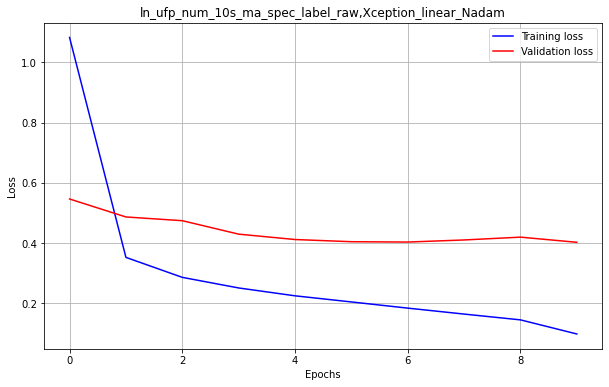

In [26]:
import matplotlib.pyplot as plt

data = pd.read_csv(filepath_or_buffer='./rishabh_model_files/logs/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.csv')

# Extract data from DataFrame
epochs = data['epoch']
train_loss = data['loss']
val_loss = data['val_loss']

# Plotting loss curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title(f'{target},{architecture}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()